# Проект: Исследование эффективности промокампании в мобильной игре.

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date,timedelta,datetime

from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
from scipy.stats import normaltest
from scipy.stats import levene
from scipy.stats import chi2_contingency
from tqdm.auto import tqdm # отображение прогресса выполнения итераций цикла в реальном времени

In [8]:
def size_dataframe(df):
    """
    Функция для определения размера датафрейма
    
    Параметры: 
    ----------
    df: датафрейм
    
    """
    rows, cols = df.shape #размер 
    print(f'Размер dataframe: число строк {rows} и число столбцов {cols}')

# Задание 1

Задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). 

#### Считываем данные 

In [9]:
# данные о времени регистрации

reg_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-kurilova/shared/problem1-reg_data.csv',sep = ';')

In [10]:
# данные о времени захода пользователей в игру

auth_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-kurilova/shared/problem1-auth_data.csv', sep = ';')

#### Изучим информацию о данных по клиентам

In [11]:
size_dataframe(reg_data)

Размер dataframe: число строк 1000000 и число столбцов 2


In [12]:
reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [13]:
reg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [14]:
size_dataframe(auth_data)

Размер dataframe: число строк 9601013 и число столбцов 2


In [15]:
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [16]:
auth_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


####  Проведём поиск NaN значений

In [17]:
reg_data.isna().any()

reg_ts    False
uid       False
dtype: bool

In [18]:
auth_data.isna().any()

auth_ts    False
uid        False
dtype: bool

- Полей, содержащих NaN значения в таблице нет 

####  Проведём поиск повторяющихся строк во всех столбцах.

In [19]:
reg_data.loc[reg_data.duplicated( )].count()

reg_ts    0
uid       0
dtype: int64

In [20]:
auth_data.loc[auth_data.duplicated( )].count()

auth_ts    0
uid        0
dtype: int64

- Повторяющихся строк не найдено

#### Посмотрим, за какой период времени данные об регистрации пользователей.

In [29]:
print('Данные о регистрации пользователей с', pd.to_datetime(reg_data['reg_ts'], unit = 's').min().date(), 'по', pd.to_datetime(reg_data['reg_ts'], unit = 's').max().date())

Данные о регистрации пользователей с 1998-11-18 по 2020-09-23


## Создадим функцию для подсчёта retention по дням

Перед проведением когортного анализа определим четыре параметра:

1. Признак формирования когорты — действие, которое объединяет людей в группу: дата регистрации
2. Размер когорты — день
3. Отчетный период — можно  задавать самостоятельно
4. Анализируемый ключевой показатель: Retention

Объединим пользователей в когорты в зависимости от даты регистраци.

Расчитаем метрику retention для каждой когорты и посмотрим как она менялась во времени 

In [30]:
def retention_rate(registr_data, users_auth_data, start_date, end_date ):
    """
    Функция для подсчёта Retention rate по дням 
    
    Параметры:
    -----------
    registr_data: данные о времени регистрации
    users_auth_data: данные о времени захода пользователей в игру
    start_date: дата начала отчётного периода
    end_date: дата окончания отчётного период
    
    """
    # Cчитываем данные
    registr_data = pd.read_csv(registr_data, sep=';')
    users_auth_data = pd.read_csv(users_auth_data, sep=';')
    
    # Время в фреймах указано в формате UNIX time - это число секунд, прошедших с 1970 года. Cконвертируем время в datetime формат.
    
    registr_data['reg_ts'] = pd.to_datetime(registr_data['reg_ts'], unit = 's') # unit = 's',поскольку время в столбце задано в секундах
    users_auth_data['auth_ts'] = pd.to_datetime(users_auth_data['auth_ts'], unit = 's')
    
    # Приведём дату к формату "YYYY-MM-DD".При использования метода "dt.date" возвращается объект типа "datetime.date",
    # у pandas нет такого встроенного типа данных, поэтому он приводит колонку к типу данных "object". 
    # Для избежания ошибок при исследовании данных приведём столбец в формат datetime
    registr_data['reg_ts'] = registr_data['reg_ts'].dt.date
    registr_data['reg_ts'] = pd.to_datetime(registr_data['reg_ts'])
    
    users_auth_data['auth_ts'] = users_auth_data['auth_ts'].dt.date
    users_auth_data['auth_ts'] = pd.to_datetime(users_auth_data['auth_ts'])
    
    # Фильтруем датафреймы, оставляем только те строки, где значения столбцов reg_ts и auth_ts находятся
    # в диапазоне между start_date и end_date 
    # Символ "@" в запросе означает, что ссылаемся на переменные внутри строки 
    registr_data = registr_data.query('reg_ts >= @start_date and reg_ts <= @end_date')
    users_auth_data = users_auth_data.query('auth_ts >= @start_date and auth_ts <= @end_date')
    
    # Объединим датафрейм 'registr_data' с 'users_auth_data' по столбцу 'uid'
    union_data = registr_data.merge(users_auth_data, how = 'left', on = 'uid')
    
    # Группируем данные по дате регистрации -'reg_ts' и дате захода в игру - 'auth_ts' и 
    # Считаем число уникальных пользователей     
    union_data = union_data.groupby(['reg_ts', 'auth_ts'], as_index = False)\
                            .agg({'uid':'nunique'})\
                            .rename(columns = {'uid':'count_users', 'reg_ts':'cohort_date'})
    
    # Создаём новый столбец с количеством дней прошедших от даты регистрации до захода в игру    
    union_data['delta_days'] = union_data['auth_ts'] - union_data['cohort_date']
    union_data['delta_days'] = union_data['delta_days'].dt.days
    union_data['cohort_date'] = union_data['cohort_date'].dt.date
    
    # Строим сводную таблицу используя метод pivot  
    cohort_analysis = union_data.pivot(index = 'cohort_date', columns = 'delta_days', values = 'count_users' )
    
    # Считаем retention rate, для этого используем функцию div() для деления датафрейма cohort_analysis на 
    # первый столбец (количество пользователей в когорте,т.е.колич. пользователей на начала периода), затем с помощью функции 
    # mul() умножаем результат на 100, чтобы получить результат в процентах. Полученный результат retention rate округляем до 
    # 2-х знаков после запятой. Метод iloc[:,0] - доступ ко всем строкам первого столбца по индексу, axis - параметр функции div
    # axis = 0 - выполнить деление для каждой когорты по строкам
    retention = round(cohort_analysis.div(cohort_analysis.iloc[:,0], axis = 0).mul(100), 2)
    
    # Визуализируем результат в виде тепловой карты
    
    del retention[0] # удалим первый столбец, для градации цветов 
    
    plt.figure(figsize=(20,20)) #зададим размер области визуализации  
    ax = sns.heatmap(data=retention.div(100, axis=0), 
                     linewidths=3, # толщина линий, разделяющихся ячейки
                     square=True, # чтобы каждая яяейка имела квадратную форму
                     cmap="Blues",# цветовая схема 
                     annot=True, # отобразить значения в ячейках
                     fmt='.0%', # значения в процентах без десятичной части
                     cbar = False, # не отображать цветовую шкалу
                     annot_kws = {"fontsize": 12}) # задаётся размер текста в ячейках)

    ax.set_title('Retention rate, %', fontsize=35) # заголовок графика, с размером шрифта 35

    ax.set_ylabel("Cohort", fontsize=15) # подпись для оси y

    ax.set_xlabel('Day', fontsize=15) # подпись для оси x
    
    return retention

## Введите данные для подсчёта Retention по дням

`Введите путь к файлам с данными о регистрации пользователей(reg_data) и путь к данным о заходе пользователей в игру(auth_data):`

In [31]:
# путь к файлам с данными о регистрации пользователей и заходом в игру
reg_data = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-kurilova/shared/problem1-reg_data.csv'
auth_data = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-kurilova/shared/problem1-auth_data.csv'

`Введите датy начала отчётного периода в формате "YYYY-MM-DD"(например, "2020-06-06") :`

In [32]:
start_date = pd.to_datetime('2020-06-06')

`Введите датy окончания отчётного периода в формате "YYYY-MM-DD"(например, "2020-06-26") :`

In [33]:
end_date = pd.to_datetime('2020-06-26')

`Воспользуемся функцией "retention_rate". Подробнее о функции - help(retention_rate)`

delta_days,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
cohort_date,,,,,,,,,,,,,,,,,,,,
2020-06-06,2.04,3.64,4.87,4.80,5.96,7.27,5.53,5.02,5.67,4.58,5.02,4.87,5.24,4.80,4.29,4.22,4.15,4.44,3.49,3.64
2020-06-07,1.38,4.36,5.23,4.80,5.89,5.45,6.98,4.22,5.09,5.31,5.09,4.87,5.01,4.14,4.80,4.43,3.63,3.71,4.36,NaN
2020-06-08,1.74,2.76,4.50,5.73,5.95,6.89,4.50,5.15,4.06,5.58,4.57,5.73,4.93,4.50,4.42,4.28,4.86,4.42,NaN,NaN
2020-06-09,1.88,3.84,4.13,5.94,5.29,6.66,5.72,4.63,5.21,4.92,5.07,5.58,4.85,4.71,3.69,4.78,4.06,NaN,NaN,NaN
2020-06-10,1.37,3.76,4.77,4.77,6.80,8.53,5.78,5.28,4.05,5.28,5.42,5.42,5.78,4.34,5.06,4.92,NaN,NaN,NaN,NaN
2020-06-11,1.73,4.47,3.82,6.13,5.41,7.07,6.13,5.12,5.19,5.70,5.27,4.55,4.62,3.54,4.40,NaN,NaN,NaN,NaN,NaN
2020-06-12,1.95,3.67,4.32,5.84,6.77,7.85,5.40,4.39,5.19,5.19,5.26,4.83,4.39,5.26,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-13,2.01,3.31,4.60,5.11,5.40,6.76,5.47,3.96,4.82,5.25,4.24,4.82,3.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-14,2.16,4.53,4.74,5.89,6.39,5.82,6.54,4.81,6.11,4.53,5.03,5.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


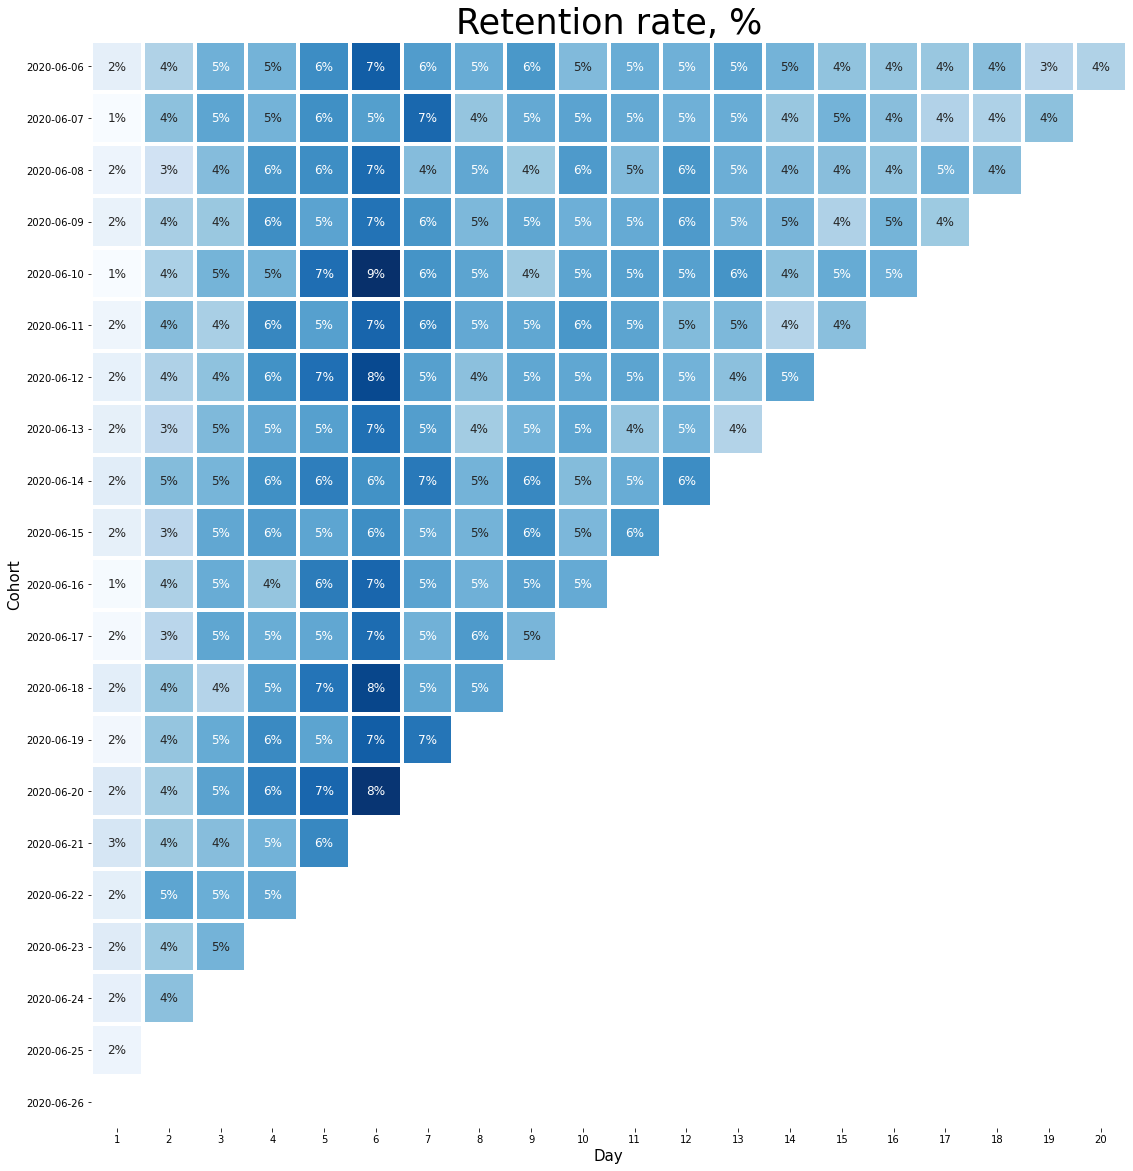

In [34]:
retention_rate(reg_data,auth_data, start_date, end_date )

По результатам исследования можно сказать,что пользователям, зарегистрированным в июне 2020-го года, игра неинтересна и удержать пользователей не получается.

# Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [35]:
# считываем данные
df = pd.read_csv('Проект_1_Задание_2.csv', sep = ';')

#### Изучим данные 

In [36]:
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [37]:
size_dataframe(df)

Размер dataframe: число строк 404770 и число столбцов 3


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [39]:
df.user_id.nunique()

404770

In [40]:
df.groupby('testgroup', as_index = False).agg({'revenue':'count'})

,testgroup,revenue
0,a,202103
1,b,202667


Типы данных определены верно, NaN значения отсутствуют, дублирующих строк нет. Группа "А" является контрольной группой, а группа "В" - тестовой группойю Данные готовы для дальнейшего анализа.

In [41]:
df.groupby('testgroup', as_index = False).agg({'revenue':'describe'})

testgroup   revenue                                                    
                count       mean         std  min  25%  50%  75%      max
0         a  202103.0  25.413720  920.768137  0.0  0.0  0.0  0.0  37433.0
1         b  202667.0  26.751287  287.324162  0.0  0.0  0.0  0.0   4000.0

Группы по числу пользователей у нас примерно одинаковые. Судя по значениям квартилей большинство пользователей в группах являются не платящими, а максимально значение revenue в группах на порядок расходится. 

Посмотрим распределения выручки у платящих пользователей.

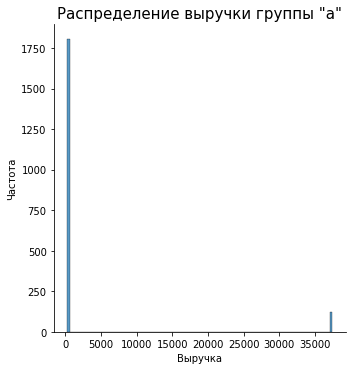

In [42]:
sns.displot(df.query('revenue > 0 and testgroup == "a"').revenue, kde=False, bins = 100)

plt.xlabel('Выручка', size=10)
plt.ylabel('Частота', size=10)
plt.title('Распределение выручки группы "a"', size=15)
plt.show()

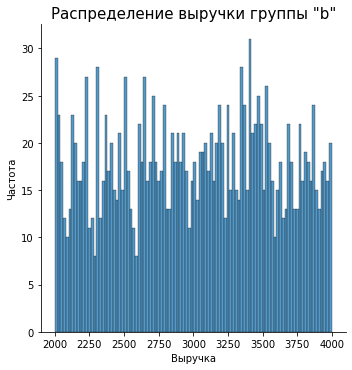

In [43]:
sns.displot(df.query('revenue > 0 and testgroup == "b"').revenue, kde=False, bins = 100)

plt.xlabel('Выручка', size=10)
plt.ylabel('Частота', size=10)
plt.title('Распределение выручки группы "b"', size=15)
plt.show()

Распределение выручки в двух группах сильно отличается. В группе "A" много низкоплатящих пользвателей и есть те, кто потратил экстремально большую сумму денег. В группе "B" платящие пользователи распределилась равномерно в диапазоне от 2000 до 4000.

`Необходимо ответить на вопрос, какие метрики стоит проанализировать для принятия решения какой набор акционных предложений можно считать лучшим. По имеющимся у нас данным проанализируем следующие метрики: `

- **Конверсия(CR)** - это число пользователей совершивших покупку, к общему числу пользователей.
- **ARPU** - средний доход на одного пользователя.
- **ARPPU** - средний доход на одного платящего пользователя.

Сформируем данные для подсчёта метрик, найдём общее число пользователей, число платящих пользователей, общую сумму покупок.

Рассчитанные метрики и сведём их в одну таблицу.

In [44]:
# Создадим новый столбец для подсчёта пользователей, совершивших покупку
# Если пользователь совершил покупку, то в столбце будет стоять "True", если нет, то "False", для этого использ. lambda функцию

df['paying_users'] = df.revenue.apply(lambda x: True if x > 0 else False)

In [45]:
df.head()

,user_id,revenue,testgroup,paying_users
0,1,0,b,False
1,2,0,a,False
2,3,0,a,False
3,4,0,b,False
4,5,0,b,False


In [46]:
# Сформируем данные для подсчёта метрик, найдём общее число пользователей, число платящих пользователей, общую сумму покупок 

metrics = df.groupby('testgroup', as_index = False)\
            .agg({'user_id':'count','paying_users':'sum','revenue':'sum'})\
            .rename(columns = {'user_id':'count_users','paying_users':'count_of_paying_users','revenue':'sum_revenue'})

In [47]:
metrics

,testgroup,count_users,count_of_paying_users,sum_revenue
0,a,202103,1928,5136189
1,b,202667,1805,5421603


#### Рассчитаем конверсию: 

In [48]:
metrics['CR,%'] = round((metrics.count_of_paying_users/metrics.count_users).mul(100),2)

In [49]:
metrics

,testgroup,count_users,count_of_paying_users,sum_revenue,"CR,%"
0,a,202103,1928,5136189,0.95
1,b,202667,1805,5421603,0.89


#### Рассчитаем ARPU:

In [50]:
metrics['ARPU'] = round(metrics.sum_revenue/metrics.count_users, 2)

In [51]:
metrics

,testgroup,count_users,count_of_paying_users,sum_revenue,"CR,%",ARPU
0,a,202103,1928,5136189,0.95,25.41
1,b,202667,1805,5421603,0.89,26.75


#### Рассчитаем ARPPU:

In [52]:
metrics['ARPPU'] = round(metrics.sum_revenue/metrics.count_of_paying_users, 2)

### Таблица рассчитанных метрик в зависимости от группы:

In [53]:
metrics

,testgroup,count_users,count_of_paying_users,sum_revenue,"CR,%",ARPU,ARPPU
0,a,202103,1928,5136189,0.95,25.41,2664.00
1,b,202667,1805,5421603,0.89,26.75,3003.66


In [54]:
print(f'ARPU в тестовой группе выше на {round(((metrics.ARPU[1]/metrics.ARPU[0]) - 1)*100)}%')
print(f'ARPPU в тестовой группе выше на {round(((metrics.ARPPU[1]/metrics.ARPPU[0]) - 1)*100)}%')
print(f'Конверсия в контрольной группе выше на {round(metrics["CR,%"][0] - metrics["CR,%"][1],2)}%')

ARPU в тестовой группе выше на 5%
ARPPU в тестовой группе выше на 13%
Конверсия в контрольной группе выше на 0.06%


**Метрики ARPU, ARPPU выше в тестовой группе, но конверсия выше в контрольной группе. Необходимо выяснить, являются ли эти значения статистически значимыми.**

Проведем тест Левена на гомогенность дисперсий и проверим данные на нормальность для подбора статистического критерия.

`Проверим распределения данных на нормальность`

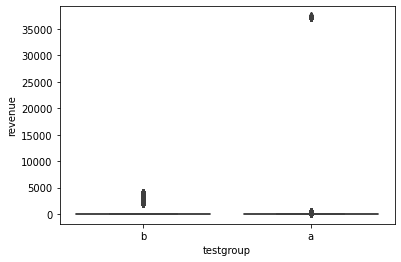

In [55]:
sns.boxplot(x = 'testgroup', y = 'revenue', data = df)

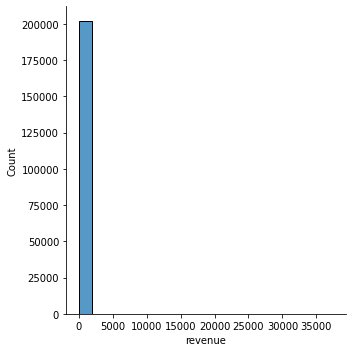

In [56]:
sns.displot(df[df.testgroup == 'a'].revenue, kde=False)

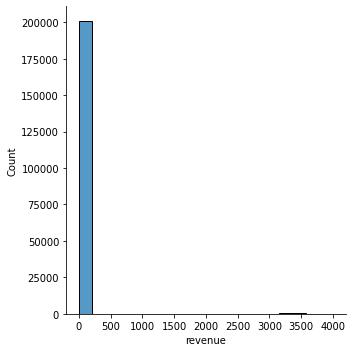

In [57]:
sns.displot(df[df.testgroup == 'b'].revenue, kde=False)

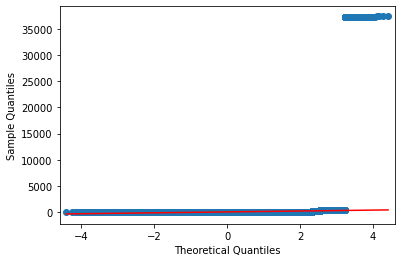

In [58]:
import statsmodels.api as sm
fig = sm.qqplot(df[df.testgroup == 'a'].revenue, line='r')
plt.show()

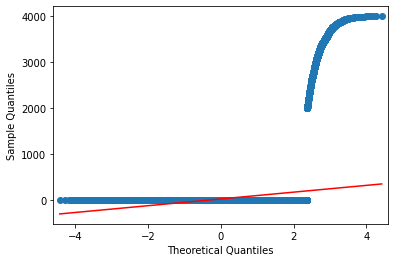

In [59]:
import statsmodels.api as sm
fig = sm.qqplot(df[df.testgroup == 'b'].revenue, line='r')
plt.show()

- Распределение значений в тестовой и в контрольной группе не близко к нормальному. В тестовой группе присутствуют выбросы.

`Проверим данные на нормальность с момощью функции scipy.stats.normaltest()`

Гипотезы:
- $H_0$: распределение не отличается от нормального
- $H_1$: распределение отличается от нормального

In [60]:
print(normaltest(df[df.testgroup == 'a'].revenue))
print(normaltest(df[df.testgroup == 'b'].revenue))

NormaltestResult(statistic=585152.7312728433, pvalue=0.0)
NormaltestResult(statistic=326622.39540856465, pvalue=0.0)


- Отвергаем Н0, оба распределения сильно отличаются от нормального.

`Проверим гомогенность дисперсии внутри групп с помощью теста Левена:`

Гипотезы:
- $H_0$: дисперсии внутри групп гомогенны
- $H_1$: дисперсии внутри групп не гомогенны

In [61]:
st, pv = levene(df[df.testgroup == 'a'].revenue, df[df.testgroup == 'b'].revenue)

prob = 0.95
alpha = 1.0 - prob
if pv <= alpha:
    print(f'Отклоняем H0, дисперсии внутри групп не гомогенны, pvalue = {pv}')
else:
    print(f'Принимаем H0, дисперсии внутри групп гомогенны, pvalue = {pv}')

Принимаем H0, дисперсии внутри групп гомогенны, pvalue = 0.5324948591043842


#### Теперь необходимо ответить на вопрос, является ли увеличение ARPU на 5% статистически значимыми или это произошло случайно. 

Поскольку U-критерий Манна Уитни тяжело интерпретировать, воспользуемся методом bootsrap для сравнения двух групп между собой.

#### Проведём статистический анализ методом bootstrap

Гипотезы:
- $H_0$: нет разницы в средней выручке между тестовой и контрольной группой
- $H_1$: есть разница в средней выручке между тестовой и контрольной группой 

In [63]:
def get_bootstrap(
    data_column_1, 
    data_column_2, 
    boot_it = 1000,
    statistic = np.mean,
    bootstrap_conf_level = 0.95 
):
    """
    Функция для проверки гипотезы с помощью бутстрапа
    
    Параметры:
    -----------
    data_column_1: числовые значения первой выборки
    data_column_2: числовые значения второй выборки
    boot_it: количество бутстрэп-подвыборок
    statistic: интересующая нас статистика
    bootstrap_conf_level: уровень значимости
    
    """
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"p_value": p_value}

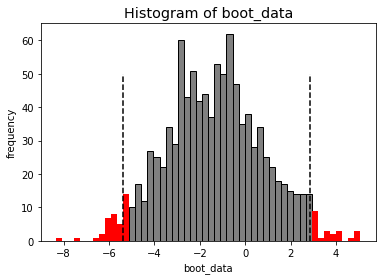

{'p_value': 0.5315626923038381}

In [64]:
#  бутстрап средних для ARPU
get_bootstrap(
    df[df.testgroup == 'a'].revenue, # числовые значения первой выборки
    df[df.testgroup == 'b'].revenue, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

**p_value > 0.05, величина ARPU не зависит от группы пользователей**

#### Теперь необходимо ответить на вопрос, является ли увеличение ARPPU в тестовой группе на 13% статистически значимыми.

Отберём только платящих пользователей и с помощью бутстрапа средних посчитаем, является ли увеличение ARPPU статистически значимым.

Гипотезы:
- $H_0$: нет разницы в средней выручке между тестовой и контрольной группой
- $H_1$: есть разница в средней выручке между тестовой и контрольной группой 

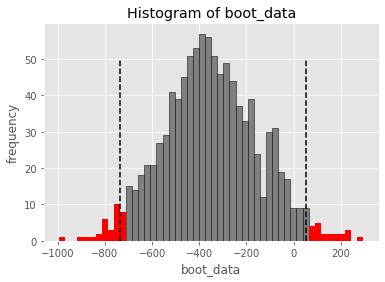

{'p_value': 0.0825170178128701}

In [65]:
#  бутстрап средних для ARPPU
get_bootstrap(
    df.query('testgroup == "a" and paying_users == True').revenue, # числовые значения первой выборки
    df.query('testgroup == "b" and paying_users == True').revenue, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

p_value > 0.05, следовательно величина ARPPU не зависит от группы пользователей.

### Оцениваем конверсию 

Конверсия(CR) контрольной группы выше, чем в тестовой, необходимо понять, является ли это различие статистически значимым. Для этого проверим, зависит ли доля оплативших пользователей от группы с помощью таблицы сопряженности и функции хи-квадрат.

Гипотезы:
- $H_0$: факт оплаты не зависит от группы
- $H_1$: факт оплаты зависит от группы  

In [66]:
# создаём таблицу сопряженности, где True - пользователь потратил деньги, False - не потратил

pd.crosstab(df.paying_users, df.testgroup)

testgroup,a,b
paying_users,,
False,200175,200862
True,1928,1805


In [67]:
# применяем фунцию хи-квадрат
stat, pv, dof, expected = chi2_contingency(pd.crosstab(df.paying_users, df.testgroup))

prob = 0.95
alpha = 1.0 - prob
if pv <= alpha:
    print(f'Отклоняем H0, факт оплаты зависит от группы, pvalue = {pv}')
else:
    print(f'Принимаем H0, факт оплаты не зависит от группы , pvalue = {pv}')

Отклоняем H0, факт оплаты зависит от группы, pvalue = 0.03647561892312613


## Выводы: 

Для принятия решения в какой группе набор акционных предложений можно считать лучшим по имеющимся у нас данным были рассчитаны  следующие метрики: конверсия(CR), средний доход на одного пользователя(ARPU), средний доход на одного платящего пользователя(ARPPU).

В результате расчёта метрик получилось, что:
- ARPU в тестовой группе выше на 5%
- ARPPU в тестовой группе выше на 13%
- Конверсия в контрольной группе выше на 0.06%

Для обоснования, является ли различие в метриках статистически значимым был применён бутстрап анализ и критерий хи-квадрат. 

В результате анализа не выявлено статистически значимой разницы между группами для метрик ARPU и ARPPU,то есть нет разницы в средней выручке между тестовой и контрольной группой, но удалось выявить статистически важное различие факта оплаты в зависимости от группы. Таким образом, увеличение ARPU и ARPPU в тестовой группе вероятнее было получено случайно и никак не свзяно с набором акционных предложений.

По результатам статистического анализа нельзя сказать, какой набор акционных предложений можно считать лучшим, всё зависит от того, какое поведение пользователей больше удовлетворяет бизнес-целям компании. Если бизнес интересует большее число платящих пользователей, но готовых тратить меньшие суммы, то не стоит вводить новый набор акционных предложений на всех пользователей, если нужно уменьшить количество платящих пользователей, но заставить их платить больше, то стоит ввести новый набор акционнных предложений.

# Задание 3

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

### Для оценки результатов прошедшего тематического события можно использовать следующий метрики:

- **Среднее время проведённое в игре**. 

Анализ времени, проведённого пользователями в игре, помогает понять как улучшить игровой процесс и сделать его более интересным и захватывающим. Например, если игроки проводят много времени на определенных уровнях или заданиях, то можно облегчить прохождение уровня, и наоборот, если уровень слишком лёгкий и пользователи проходят его быстро, то можно усложнить его. Так же количество времени, проведённое в игре может быть связано с количеством денег, которые игроки готовы потратить на покупки в игре. 

- **Конверсия:**

    - соотношение количества игроков, успешно прошедших все уровни тематического события, к общему количеству участников;  
    - отношение количества игроков, совершивших покупку, к общему количеству участников; 
    - отношение количество игроков, принявших участие в событии, к общему числу пользователей в игре.и т.д.

1. Если данная метрика достаточно высокая, то это тематическое событие было интересно пользователям. Если нет, то стоит разобраться по какой причине и доработать продукт.
2. Можно объединить пользователей по когортам и определить, какие типы пользователей наиболее заинтересованы в продукте.
3. Оценка потенциальной доходности от продукта. Если данная метрика высокая, это может привести к увеличению продаж или дохода в будущем, поскольку пользователям понравилось это тематическое событие, вероятно и продукт в целом.
4. Если значение метрики низкое, это может указывать на то, что стоит доработать это тематическое событие(улучшить игровой процесс, изменить дизайн и прочее).

- **ARPU** - средний доход на одного пользователя / **ARPPU** - средний доход на одного платящего пользователя.

Если метрика во время тематического события выросла, значит пользователи стали лояльнее, игра стала доходнее, маркетинг эффективный, игровой процесс интересный.

- **Сумма дохода от тематичского мероприятия**

- **DAU, WAU, MAU** - количество уникальных пользователей, которые использовали игру в течение одного дня/недели/месяца.

Повышение DAU, WAU и MAU может говорить о росте популярности игры и успешности маркетинговых компаний, тематического события.

`Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?`

При усложнении механики игры набор метрик можно оставить тот же. Важно следить за вовлечённостью пользователей в игру и метриками дохода, чтобы понимать, как сказываются изменения на поведение игроков. Дополнительно можно рассмотреть следующие метрики:

- Процент игроков, покинувших игру после неудачных попыток прохождения уровня в разерезе количества поражений.
- Процент игроков, вернувшихся в игру после отката на несколько уровней.
- Средняя сумма покупок пользователей после поражения в разерезе количества поражений.
- Среднее количество поражений перед выходом из игры.
- Тратят ли пользователи больше денег после отката на несколько уровней.